In [34]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import torch_dip_utils as utils
import math

import time

import pywt

env: CUDA_VISIBLE_DEVICES=0


## Hyperparameters

In [35]:
#set up hyperparameters, net input/output sizes, and whether the problem is compressed sensing

LR = 1e-4 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 10000 # number iterations
WD = 1e-4 # weight decay for l2-regularization

INPUT_SIZE = 32 # input seed
NGF = 1000 # number of filters per layer
NC = 1 #num channels in the net I/0

OUTPUT_SIZE = 128
X_OUTPUT = np.arange(OUTPUT_SIZE)

In [36]:
CUDA = torch.cuda.is_available()
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


## Create test series

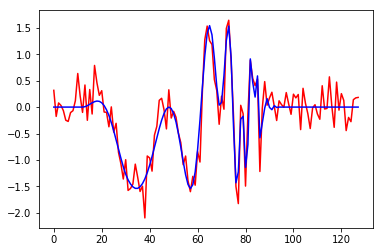

In [37]:
noise_std = 0.3
noise_mean = 0

#y0 = np.zeros((OUTPUT_SIZE))
y0 = pywt.data.demo_signal(name='Hypchirps', n=OUTPUT_SIZE)
y1 = y0.copy() + (noise_std * np.random.randn(OUTPUT_SIZE)) + noise_mean

plt.figure()
plt.plot(y1, color='r')
plt.plot(y0, color='b')

In [38]:
def get_stats(x):
    a = np.min(x)
    b = np.max(x)
    mu = (a+b)/2.0
    sigma = (b-a)/2.0
    return [mu, sigma]
    #mu = np.mean(x)
    #sigma = np.std(x)
    #return [mu, sigma]

MU = get_stats(y1)[0]
SIGMA = get_stats(y1)[1]

def normalise(x):
    return (x-MU)/SIGMA

def renormalise(x):
    return x*SIGMA + MU

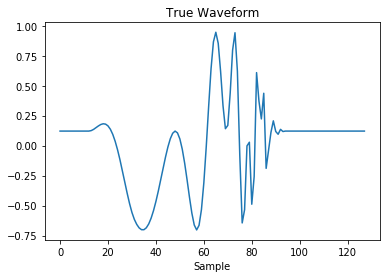

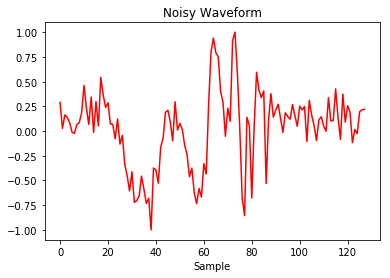

In [39]:
y0 = normalise(y0)
plt.figure()
plt.plot(X_OUTPUT, y0)
plt.xlabel("Sample")
plt.title("True Waveform")
plt.show()

y1 = normalise(y1)
plt.figure()
plt.plot(X_OUTPUT, y1, color='r')
plt.xlabel("Sample")
plt.title("Noisy Waveform")
plt.show()

In [40]:
y = torch.Tensor(y1)
#y = normalise(y)
y = Variable(y.type(dtype))
y = y.cuda()

mse = torch.nn.MSELoss().type(dtype)

In [41]:
class DCGAN1(nn.Module):
    def __init__(self, nz=1, ngf=1, output_size=32, nc=1):
        super(DCGAN1, self).__init__()
        self.nc = nc
        self.output_size = output_size

        # Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        # Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size

        self.conv1 = nn.ConvTranspose1d(nz, ngf, 4, 4, 0, bias=False)
        
        #self.fc = nn.Linear(output_size*nc, output_size*nc, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.fc(x)

        return x
    
class DCGAN2(nn.Module):
    def __init__(self, nz=1, ngf=64, output_size=128, nc=1):
        super(DCGAN2, self).__init__()
        self.nc = nc
        self.output_size = output_size

        # Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        # Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size

        self.conv1 = nn.ConvTranspose1d(nz, ngf, 2, 2, 0, bias=False)
        self.conv2 = nn.ConvTranspose1d(ngf, nc, 2, 2, 0, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = torch.tanh(x)

        return x
    
class DCGAN3(nn.Module):
    def __init__(self, nz=1, ngf=1, output_size=32, nc=1):
        super(DCGAN3, self).__init__()
        self.nc = nc
        self.output_size = output_size

        # Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        # Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size
        
        self.fc = nn.Linear(INPUT_SIZE, output_size*nc, bias=False)

    def forward(self, x):
        x = self.fc(x)

        return x

In [42]:
net = DCGAN3(output_size = OUTPUT_SIZE , nc = NC) # initialize network

if CUDA: # move network to GPU if available
    net.cuda()
    print("USING CUDA")
else:
    print("RUNNING ON CPU")
    
allparams = [x for x in net.parameters()] #specifies which to compute gradients of
print(len(allparams))
#allparams = allparams[:-1] # get rid of last item in list (fc layer) because it's memory intensive

z = Variable(torch.zeros(INPUT_SIZE).type(dtype).view(1,1,INPUT_SIZE))
z.data.normal_().type(dtype)

# Define optimizer
optim = torch.optim.RMSprop(allparams,lr=LR,momentum=MOM, weight_decay=WD)

USING CUDA
1


9999


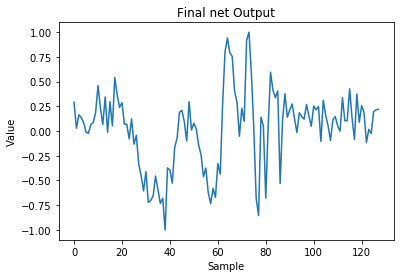

Execution Time:  4.58 s


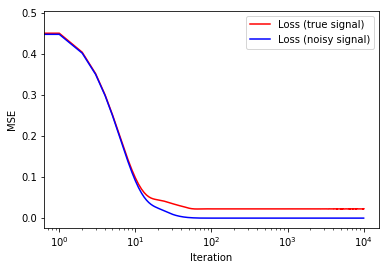

In [43]:
mse_log_true = np.zeros((NUM_ITER))
mse_log_noisy = np.zeros((NUM_ITER))

start = time.time()

for i in range(NUM_ITER):
    optim.zero_grad() # clears graidents of all optimized variables
    out = net(z) # produces wave (in form of data tensor) i.e. G(z,w)
    
    loss = mse(out, y) # calculate loss between AG(z,w) and Ay
         
    # DCGAN output is in [-1,1]. Renormalise to [0,1] before plotting
    wave = out[0].detach().reshape(-1, NC).cpu().numpy()

    mse_log_true[i] = np.mean((np.squeeze(y0) - np.squeeze(wave))**2)
    mse_log_noisy[i] = np.mean((np.squeeze(y1) - np.squeeze(wave))**2)
    
    if i == NUM_ITER - 1:
        print(i)
        
        plt.plot(X_OUTPUT, wave)
        #plt.plot(np.arange(1024), y0_denoised, color='r')
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.title("Final net Output")
        plt.show()
    
    loss.backward()
    optim.step()
    
end = time.time()
print("Execution Time: ", round(end-start, 2), "s")

plt.figure()
plt.plot(np.arange(NUM_ITER), mse_log_true, color='r', label='Loss (true signal)')
plt.plot(np.arange(NUM_ITER), mse_log_noisy, color='b', label='Loss (noisy signal)')
plt.legend()
plt.xlabel("Iteration")
plt.xscale("log")
plt.ylabel("MSE")
plt.show()

In [44]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)

4096
